In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from get_data import get_weather_data, get_temp
from edo_model_yang import system_odes, solve_model, plot_fit
from parameters import d, theta_m, mu_a, mu_m, gamma_m, C_yang, sup_cap_sin, sup_cap_yang

Neste notebook, por meio de simulação numérica, utilizando dados sintéticos foi realida uma comparação da saída do modelo nas seguintes situações: 
- parâmetros ontomológicos fixos;
- parâmetros ontomológicos variando de acordo com a temperatura seguindo Yang; 
- adição da capacidade suporte variando no tempo seguindo a formulação do Yang 2016. 

Modelo com os parâmetros fixos:

In [30]:
t = np.arange(0, 357)


phi = 0

N = 256088

y0 = [64854, N, 0, 0, N, 0, 20, 0]

# parâmetros fixos 
MU_H = 1/(365*76)    #human mortality rate - day^-1
ALPHA_H = 0.1      #recovering rate - day^-1
THETA_H = 0.027   #intrinsic incubation rate - day^-1
K = 0.5          #fraction of female mosquitoes hatched from all egs
C_A = 0.0      #control effort rate on aquatic phase
C_M = 0.0    #control effort rate on terretrial phase

par_fixed = MU_H, THETA_H, ALPHA_H, K, C_A, C_M

def model_params_fixed(t, y0, par_fixed): 
    
    #start_date = '2010-01-02'
    b = lambda t: 0.5
    beta = lambda t: 0.75

    par_fit = b, beta
    
    d_ = lambda t: 5.6
    
    gamma_m_ = lambda t: 0.095
    
    mu_a_ = lambda t: 0.24
    
    mu_m_ = lambda t: 0.055
    
    theta_m_ = lambda t: 0.11
    
    C_ = lambda t: 65600
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    r_fix = solve_model(t, y0, par_fit, param_ento, par_fixed)
    
    return r_fix


In [31]:
%%time

r_fix = model_params_fixed(t, y0, par_fixed)

CPU times: user 55.5 ms, sys: 3.2 ms, total: 58.7 ms
Wall time: 57.1 ms


Modelo com os parâmetros variáveis (Temperatura): 

In [32]:
def model_ento_temp(t, y0, par_fixed, T): 
    
    #start_date = '2010-01-02'
    b = lambda t:0.5
    beta = lambda t:0.75


    par_fit = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)
    
    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = lambda t: 65600
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    r = solve_model(t, y0, par_fit, param_ento, par_fixed)
    
    return r

In [33]:
T1 = np.round(get_temp(start_date = '2011-01-08', end_date = '2011-12-31'), 1)

In [34]:
%%time
r_c_t_1 = model_ento_temp(t, y0, par_fixed, T1)

CPU times: user 442 ms, sys: 5.73 ms, total: 447 ms
Wall time: 443 ms


In [35]:
T2 = np.round(get_temp(start_date = '2015-06-08', end_date = '2016-05-31'), 1)

r_c_t_2  = model_ento_temp(t, y0, par_fixed, T2)

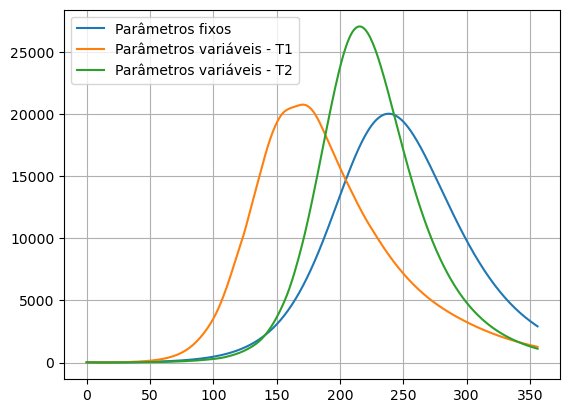

In [36]:
fig,ax = plt.subplots()

ax.plot(r_fix.y[6], label = 'Parâmetros fixos')
ax.plot(r_c_t_1.y[6], label = 'Parâmetros variáveis - T1')
ax.plot(r_c_t_2.y[6], label = 'Parâmetros variáveis - T2')

ax.grid()
ax.legend()
plt.show()

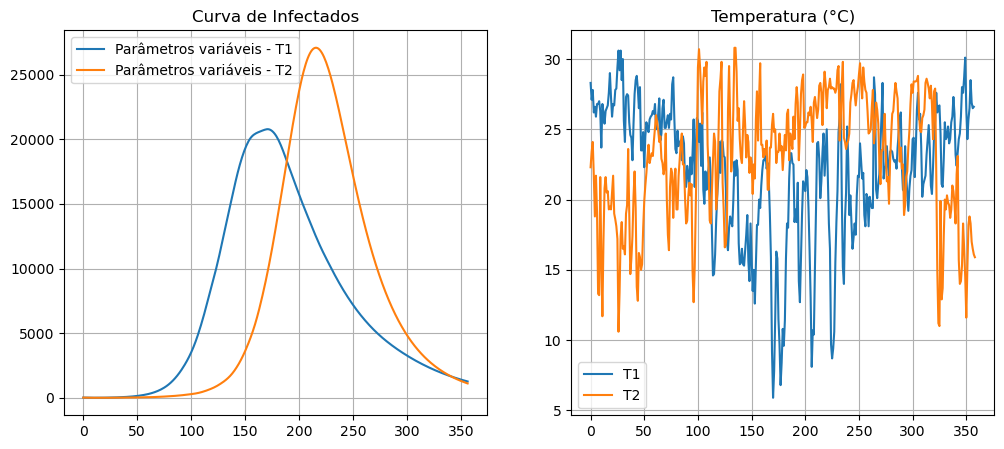

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (12,5))

ax[0].plot(r_c_t_1.y[6], label = 'Parâmetros variáveis - T1')
ax[0].plot(r_c_t_2.y[6], label = 'Parâmetros variáveis - T2')

ax[0].grid()
ax[0].legend()
ax[0].set_title('Curva de Infectados')

ax[1].plot(T1, label = 'T1')
ax[1].plot(T2, label = 'T2')

ax[1].grid()
ax[1].legend()
ax[1].set_title('Temperatura (°C)') 
plt.show()

Introduzindo uma capacidade suporte variável: 

**Lembre-se que a capacidade suporte seguindo a fórmula do yang é calculada utilizando anos anteriores, sendo assim, perdemos os k primeiros valores.** 

In [38]:
def model_ento_temp_cap(t, y0, par_fixed, T, df_we): 
    
    #start_date = '2010-01-02'
    b = lambda t:0.5
    beta = lambda t:0.75

    par_fit = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)
    
    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = C_yang(df_we, k=7,w1=0.5, C0=5,C1=30,C2 =0.1)
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    r = solve_model(t, y0, par_fit, param_ento, par_fixed)
    
    return r

def model_ento_temp_cap_sin(t, y0, par_fixed, T): 
    
    #start_date = '2010-01-02'
    b = lambda t:0.5
    beta = lambda t:0.75

    par_fit = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)
    
    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = lambda t: sup_cap_sin(t, C0 = 1.5, epsilon = 0.8, t_omega = 120, phi = -2)*(10**4)
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    r = solve_model(t, y0, par_fit, param_ento, par_fixed)
    
    return r

In [39]:
df_we = get_weather_data()

df_we_1 = df_we.loc[(df_we.index >= '2011-01-01') & (df_we.index <= '2011-12-31')]
df_we_2 = df_we.loc[(df_we.index >= '2015-06-01') & (df_we.index <= '2016-05-31')]

k = 7
w1 = 0.5
C0 = 5
C1 = 30
C2 = 0.1

C_1 = sup_cap_yang(df_we_1, k, w1, C0, C1, C2)*(10**4)

C_2 = sup_cap_yang(df_we_2, k, w1, C0, C1, C2)*(10**4)

r_c_t_1_cap_1  = model_ento_temp_cap(t, y0, par_fixed, T1, df_we_1)

r_c_t_2_cap_2  = model_ento_temp_cap(t, y0, par_fixed, T2, df_we_2) 

In [40]:
%%time
C_2 = sup_cap_yang(df_we_2, k, w1, C0, C1, C2)*(10**4)

CPU times: user 4.83 ms, sys: 1 µs, total: 4.83 ms
Wall time: 4.83 ms


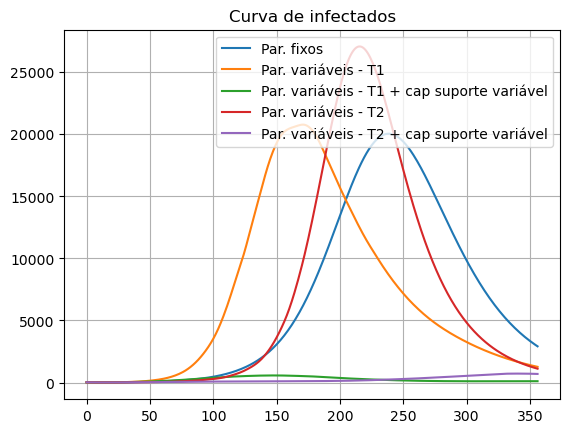

In [41]:
fig,ax = plt.subplots()

ax.plot(r_fix.y[6], label = 'Par. fixos')
ax.plot(r_c_t_1.y[6], label = 'Par. variáveis - T1')
ax.plot(r_c_t_1_cap_1.y[6], label = 'Par. variáveis - T1 + cap suporte variável')
ax.plot(r_c_t_2.y[6], label = 'Par. variáveis - T2')
ax.plot(r_c_t_2_cap_2.y[6], label = 'Par. variáveis - T2 + cap suporte variável')

ax.grid()
ax.legend()
ax.set_title('Curva de infectados')
plt.show()

Adicionando também uma capacidade suporte que varia de forma senoidal 

In [42]:
%%time
r_c_t_1_cap_1  = model_ento_temp_cap(t, y0, par_fixed, T1, df_we_1)

CPU times: user 3.48 s, sys: 7.07 ms, total: 3.49 s
Wall time: 3.49 s


In [43]:


r_c_t_2_cap_2  = model_ento_temp_cap(t, y0, par_fixed, T1, df_we_2) 

r_c_t_2_cap_3  = model_ento_temp_cap_sin(t, y0, par_fixed, T1) 

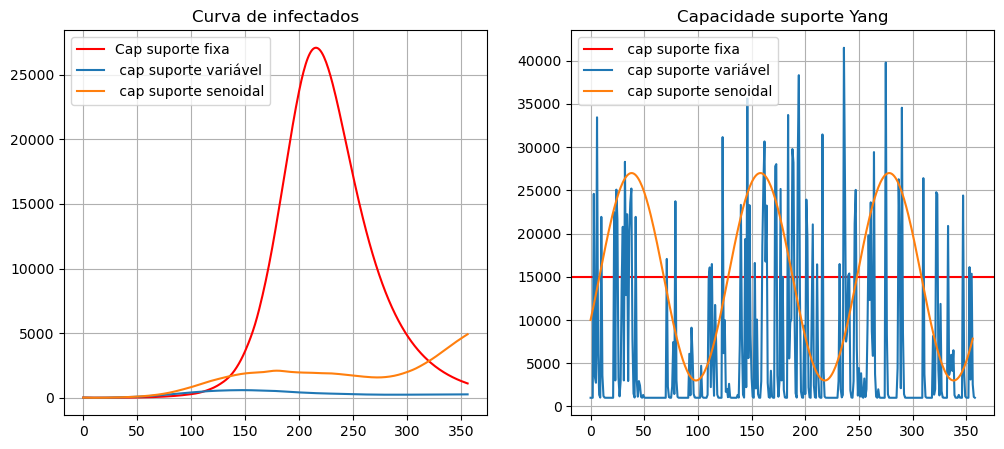

In [44]:
C_sin = lambda t: sup_cap_sin(t, C0 = 1.5, epsilon = 0.8, t_omega = 120, phi = -2)*(10**4)

fig,ax = plt.subplots(1, 2, figsize = (12,5))

ax[0].plot(r_c_t_2.y[6], label = 'Cap suporte fixa', color = 'red')
ax[0].plot(r_c_t_2_cap_2.y[6], label = ' cap suporte variável', color = 'tab:blue')
ax[0].plot(r_c_t_2_cap_3.y[6], label = ' cap suporte senoidal', color = 'tab:orange')

ax[0].grid()
ax[0].legend()
ax[0].set_title('Curva de infectados')

ax[1].axhline(1.5*(10**4), label = ' cap suporte fixa', color = 'red')

ax[1].plot(C_2.values, label = ' cap suporte variável', color = 'tab:blue')

ax[1].plot(C_sin(t), label = ' cap suporte senoidal', color = 'tab:orange')

ax[1].grid()
ax[1].legend(loc=2)
ax[1].set_title('Capacidade suporte Yang')

plt.show()

Vamos agora considerar que o valor b, taxa média de mordidas por mosquito por dia e beta_m e beta_h que são as taxa de contato variam de acordo com a temperatura. Nesse caso, usando como ref o artigo da mordecai usamos uma função Brière e consideramos que não há transmissão para T menor que 18 ou T maior que 34. 

In [45]:
def briere(T, a, b, c):
    
    return a*T*(T-b)*((c-T)**(1/2))


T = np.arange(-1.7, 41.7, 0.1)

def b(T):
    
    values = []
    for temp in T:
        if (temp > 34) | (temp < 18):
            v = 0
        else: 
            v = briere(temp, a = 0.0011, b=18, c = 34)
            
        values.append(v)
    
    return values


def b_(T):
    
    dias = np.arange(0, len(T))
  
    f = interpolate.interp1d(dias, b(T))
    
    return f 


def beta(T):
    
    values = []
    for temp in T:
        if (temp > 34) | (temp < 18):
            v = 0
        else: 
            v = briere(temp, a = 0.0012, b=18, c = 34)
            
        values.append(v)
    
    return values

def beta_(T):
    
    dias = np.arange(0, len(T))
  
    f = interpolate.interp1d(dias, beta(T))
    
    return f 

In [46]:
from scipy import interpolate
print(T1[0:2])
print(beta(T1[0:2]))
print(beta_(T1)(0))
print(beta_(T1)(1))

[28.3 27.1]
[0.8351074039791528, 0.7773497703772736]
0.8351074039791528
0.7773497703772736


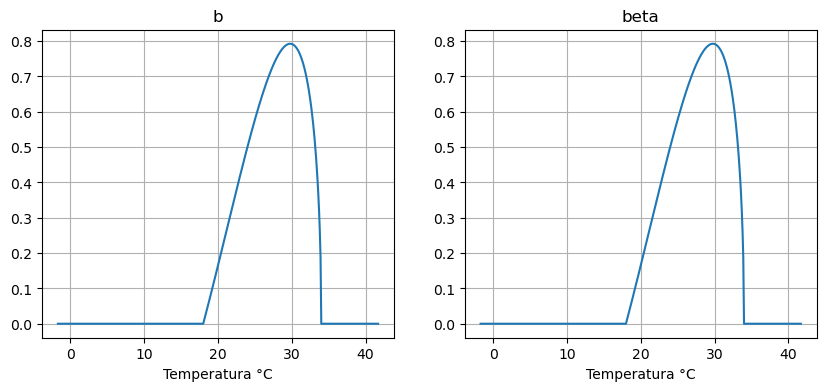

In [47]:
fig, ax = plt.subplots(1,2, figsize= (10,4))

ax[0].plot(T, b(T))

ax[0].set_title('b')

ax[0].set_xlabel('Temperatura °C')

ax[0].grid()

ax[1].plot(T, b(T))

ax[1].set_title('beta')

ax[1].set_xlabel('Temperatura °C')

ax[1].grid()

plt.show()


In [48]:
def model_ento_temp_c_r(t, y0, par_fixed, T): 
    
    #start_date = '2010-01-02'
    b = b_(T)
    beta = beta_(T)

    par_fit = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)
    
    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = lambda t: 65600
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    r = solve_model(t, y0, par_fit, param_ento, par_fixed)
    
    return r

In [49]:
r_c_t_1_b = model_ento_temp_c_r(t, y0, par_fixed, T1)
r_c_t_2_b = model_ento_temp_c_r(t, y0, par_fixed, T2)

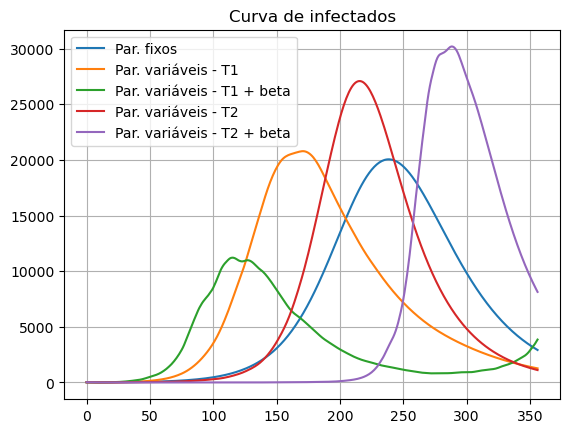

In [50]:
fig,ax = plt.subplots()

ax.plot(r_fix.y[6], label = 'Par. fixos')
ax.plot(r_c_t_1.y[6], label = 'Par. variáveis - T1')
ax.plot(r_c_t_1_b.y[6], label = 'Par. variáveis - T1 + beta')
ax.plot(r_c_t_2.y[6], label = 'Par. variáveis - T2')
ax.plot(r_c_t_2_b.y[6], label = 'Par. variáveis - T2 + beta')

ax.grid()
ax.legend()
ax.set_title('Curva de infectados')
plt.show()

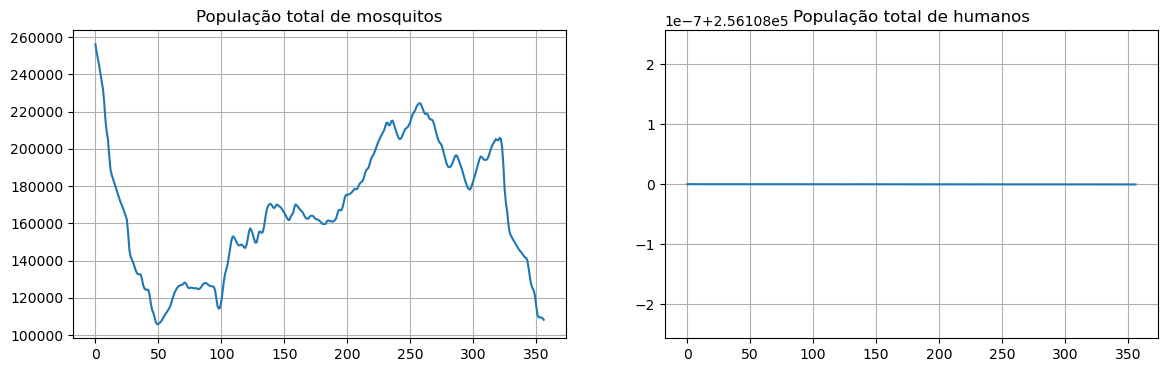

In [51]:
fig, ax = plt.subplots(1,2, figsize = (14,4))

ax[0].plot( r_c_t_2_b.y[1] +r_c_t_2_b.y[2] + r_c_t_2_b.y[3])

ax[0].set_title('População total de mosquitos')

ax[0].grid()

ax[1].plot( r_c_t_2_b.y[4] + r_c_t_2_b.y[5] + r_c_t_2_b.y[6] + r_c_t_2_b.y[7])

ax[1].set_title('População total de humanos')

ax[1].grid()

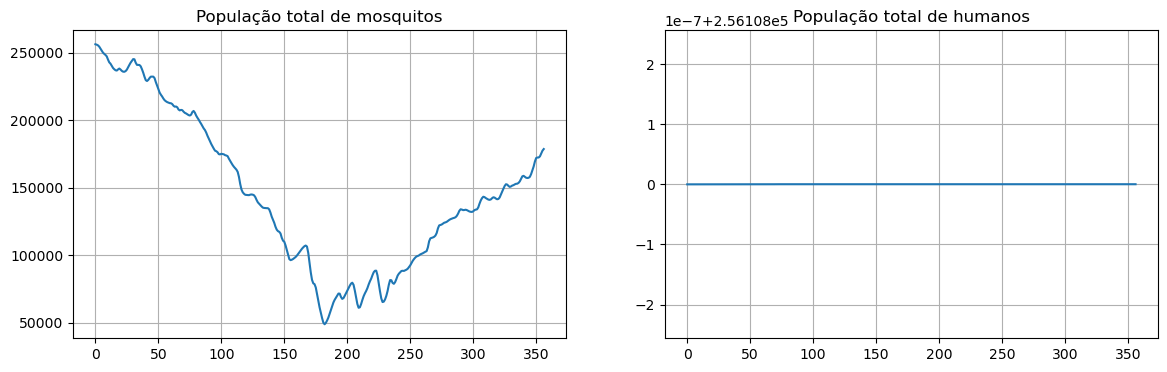

In [52]:
fig, ax = plt.subplots(1,2, figsize = (14,4))

ax[0].plot( r_c_t_1_b.y[1] +r_c_t_1_b.y[2] + r_c_t_1_b.y[3])

ax[0].set_title('População total de mosquitos')

ax[0].grid()

ax[1].plot( r_c_t_1_b.y[4] + r_c_t_1_b.y[5] + r_c_t_1_b.y[6] + r_c_t_1_b.y[7])

ax[1].set_title('População total de humanos')

ax[1].grid()